In [1]:
import pandas as pd
import numpy as np
from preprocess import base_data
from pathlib import Path
import hydra
import yaml
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
import optuna
import os
from sklearn.metrics import log_loss
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import catboost as cb
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture

pd.set_option('display.max_columns', None)


In [2]:
def haversine(lat1, lon1, lat2, lon2):
    # Radius of the Earth in kilometers
    R = 6371.0

    # Convert coordinates from degrees to radians
    lat1_rad = np.radians(lat1)
    lon1_rad = np.radians(lon1)
    lat2_rad = np.radians(lat2)
    lon2_rad = np.radians(lon2)

    # Difference in coordinates
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad

    # Haversine formula
    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    # Distance in kilometers
    distance = R * c
    return distance

In [3]:
file_path = '../config/config.yaml'

# ファイルを開いて内容を読み込む
with open(file_path, 'r', encoding='utf-8') as file:
    yaml = yaml.safe_load(file)

# featuresリストを取得
features = yaml.get('features', [])

data = [pd.read_pickle(f"../features/{f}.pkl") for f in features]
data = pd.concat(data, axis=1)

In [4]:
# Handle possible division by zero
data.replace([np.inf, -np.inf], np.nan, inplace=True)

# 各行の欠損値の数を計算
data['missing_values_count'] = data.isna().sum(axis=1)

In [5]:
state_to_coords = {
    'AL': (32.806671, -86.791130), 'AK': (61.370716, -152.404419), 'AZ': (33.729759, -111.431221),
    'AR': (34.969704, -92.373123), 'CA': (36.116203, -119.681564), 'CO': (39.059811, -105.311104),
    'CT': (41.597782, -72.755371), 'DE': (39.318523, -75.507141), 'FL': (27.766279, -81.686783),
    'GA': (33.040619, -83.643074), 'HI': (21.094318, -157.498337), 'ID': (44.240459, -114.478828),
    'IL': (40.349457, -88.986137), 'IN': (39.849426, -86.258278), 'IA': (42.011539, -93.210526),
    'KS': (38.526600, -96.726486), 'KY': (37.668140, -84.670067), 'LA': (31.169546, -91.867805),
    'ME': (44.693947, -69.381927), 'MD': (39.063946, -76.802101), 'MA': (42.230171, -71.530106),
    'MI': (43.326618, -84.536095), 'MN': (45.694454, -93.900192), 'MS': (32.741646, -89.678696),
    'MO': (38.456085, -92.288368), 'MT': (46.921925, -110.454353), 'NE': (41.125370, -98.268082),
    'NV': (38.313515, -117.055374), 'NH': (43.452492, -71.563896), 'NJ': (40.298904, -74.521011),
    'NM': (34.840515, -106.248482), 'NY': (42.165726, -74.948051), 'NC': (35.630066, -79.806419),
    'ND': (47.528912, -99.784012), 'OH': (40.388783, -82.764915), 'OK': (35.565342, -96.928917),
    'OR': (44.572021, -122.070938), 'PA': (40.590752, -77.209755), 'RI': (41.680893, -71.511780),
    'SC': (33.856892, -80.945007), 'SD': (44.299782, -99.438828), 'TN': (35.747845, -86.692345),
    'TX': (31.054487, -97.563461), 'UT': (40.150032, -111.862434), 'VT': (44.045876, -72.710686),
    'VA': (37.769337, -78.169968), 'WA': (47.400902, -121.490494), 'WV': (38.491226, -80.954570),
    'WI': (44.268543, -89.616508), 'WY': (42.755966, -107.302490)
}

# Apply the mapping to the dataset to create new latitude and longitude columns
data['Latitude'] = data['State'].map(lambda x: state_to_coords[x][0] if x in state_to_coords else None)
data['Longitude'] = data['State'].map(lambda x: state_to_coords[x][1] if x in state_to_coords else None)
data['BankState_Latitude'] = data['BankState'].map(lambda x: state_to_coords[x][0] if x in state_to_coords else None)
data['BankState_Longitude'] = data['BankState'].map(lambda x: state_to_coords[x][1] if x in state_to_coords else None)

# Calculate the distance between State and BankState
data['State_BankState_Distance'] = data.apply(lambda x: haversine(x['Latitude'], x['Longitude'], 
                                                                   x['BankState_Latitude'], x['BankState_Longitude']) 
                                              if pd.notnull(x['Latitude']) and pd.notnull(x['BankState_Latitude']) 
                                              else None, axis=1)

In [6]:
train = data[data["train"]==True].drop(columns="train")
test = data[data['train'] == False]
test = test.drop(['train','MIS_Status'],axis=1)


In [7]:
X = train[['Term']]
# スケーラーの初期化と適用
scaler = StandardScaler()
X = scaler.fit_transform(X)
# クラスタ数の候補を設定
n_components = np.arange(1, 10)

# BICを格納するためのリスト
bics = []

# 各クラスタ数に対してGMMをフィットし、BICを計算
for n in n_components:
    gmm = GaussianMixture(n_components=n, random_state=0)
    gmm.fit(X)
    bics.append(gmm.bic(X))

X = pd.DataFrame(X,columns=["Term"])

# クラスタ数を9に設定し、GMMをフィット
gmm = GaussianMixture(n_components=9, random_state=0)
gmm.fit(X)

# 各データポイントのクラスタ割り当てを取得
cluster_assignments = gmm.predict(X)

# クラスタ割り当て結果をデータフレームに追加
X_clustered = X.copy()
train['Term_Cluster'] = cluster_assignments

# 'Term' 列の選択
X_test = test[['Term']]

# 訓練データでフィットさせたGMMを使用してクラスタ割り当てを予測
test['Term_Cluster'] = gmm.predict(X_test)

In [8]:
category_features = ['State','BankState', 'Sector',  'NewExist','UrbanRural','RevLineCr', 'LowDoc','Franchise','IsSameState','Term_Cluster']

for col in category_features:
    train[col] = train[col].astype(str)
    test[col] = test[col].astype(str)

In [9]:
train = train.drop('City',axis=1)
test = test.drop('City',axis=1)

In [10]:
from sklearn.model_selection import KFold

# クロスバリデーションの設定
n_splits = 5
kf = KFold(n_splits=n_splits)

# OOF予測用の空配列
oof_preds = np.zeros(train.shape[0])

# テストデータ予測用の空配列
test_preds = np.zeros(test.shape[0])

# クロスバリデーション
for train_index, val_index in kf.split(train):
    X_train, X_val = train.iloc[train_index], train.iloc[val_index]

    # 目的変数の設定
    y_train, y_val = X_train['MIS_Status'], X_val['MIS_Status']

    X_train = X_train.drop(['MIS_Status'], axis=1)
    X_val = X_val.drop(['MIS_Status'], axis=1)

    # モデルの訓練
    model = cb.CatBoostClassifier(verbose=False, early_stopping_rounds=100)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)],cat_features=category_features)

    # OOF予測
    oof_preds[val_index] = model.predict_proba(X_val)[:, 1]

    # テストデータに対する予測
    test_preds += model.predict_proba(test)[:, 1] / n_splits

# 訓練データにOOF予測を追加
train['catboost_preds'] = oof_preds

# テストデータに予測を追加
test['catboost_preds'] = test_preds

In [11]:
# 訓練データとテストデータのCSVファイルに保存する列の選択
train_csv = train[['ID', 'catboost_preds']]
test_csv = test[['ID', 'catboost_preds']]

# CSVファイルに保存
train_csv_path = '../data/train_cb_predictions.csv'
test_csv_path = '../data/test_cb_predictions.csv'

train_csv.to_csv(train_csv_path, index=False)
test_csv.to_csv(test_csv_path, index=False)

train = train.drop(['ID', 'catboost_preds'],axis=1)
test = test.drop(['ID', 'catboost_preds'],axis=1)

In [12]:
X_train = train.drop('MIS_Status', axis=1)
y_train = train['MIS_Status']

# Further splitting the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [13]:
# CatBoostデータセットの作成
train_pool = cb.Pool(X_train, y_train,cat_features=category_features)
test_pool = cb.Pool(X_val, y_val,cat_features=category_features)

In [14]:
models = []
for seed in range(10):
    # データサンプリング
    train_sample = X_train.sample(frac=0.8, random_state=seed)
    y_sample = y_train[train_sample.index]

    # モデルの学習
    cat_clf = cb.CatBoostClassifier()  # 進行状況を表示しない場合はverbose=0
    cat_clf.fit(train_sample, y_sample,cat_features=category_features)

    # 検証データに対する予測
    y_pred = cat_clf.predict(X_val)
    y_pred_proba = cat_clf.predict_proba(X_val)[:, 1]  # AUCの計算に使用

    # モデルをリストに追加
    models.append(cat_clf)

Learning rate set to 0.042135
0:	learn: 0.6493349	total: 65.7ms	remaining: 1m 5s
1:	learn: 0.6124356	total: 139ms	remaining: 1m 9s
2:	learn: 0.5783284	total: 208ms	remaining: 1m 9s
3:	learn: 0.5493030	total: 332ms	remaining: 1m 22s
4:	learn: 0.5230367	total: 421ms	remaining: 1m 23s
5:	learn: 0.4982316	total: 510ms	remaining: 1m 24s
6:	learn: 0.4774672	total: 587ms	remaining: 1m 23s
7:	learn: 0.4571716	total: 681ms	remaining: 1m 24s
8:	learn: 0.4383979	total: 813ms	remaining: 1m 29s
9:	learn: 0.4220169	total: 902ms	remaining: 1m 29s
10:	learn: 0.4071208	total: 992ms	remaining: 1m 29s
11:	learn: 0.3951515	total: 1.07s	remaining: 1m 27s
12:	learn: 0.3843063	total: 1.17s	remaining: 1m 29s
13:	learn: 0.3741879	total: 1.26s	remaining: 1m 29s
14:	learn: 0.3656286	total: 1.34s	remaining: 1m 28s
15:	learn: 0.3587547	total: 1.37s	remaining: 1m 24s
16:	learn: 0.3520399	total: 1.45s	remaining: 1m 24s
17:	learn: 0.3458664	total: 1.54s	remaining: 1m 24s
18:	learn: 0.3397905	total: 1.62s	remaining: 1

In [15]:
# 3. すべてのモデルを使用してトレーニングセットとテストセットの予測を行う。
y_preds_train = []
y_preds_test = []
for model in models:
    y_preds_train.append(model.predict_proba(X_train)[:, 1])
    y_preds_test.append(model.predict_proba(X_val)[:, 1])

In [16]:
# 4. 予測結果を平均して、最終的な予測を得る。
y_pred_train = np.mean(y_preds_train, axis=0)
y_pred = np.mean(y_preds_test, axis=0)

In [17]:
print(roc_auc_score(y_val, y_pred))
total_cases = len(y_val)  # テストデータの総数
TP = (y_val == 1) & (y_pred >= 0.5)  # True positives
FP = (y_val == 0) & (y_pred >= 0.5)  # False positives
TN = (y_val == 0) & (y_pred < 0.5)  # True negatives
FN = (y_val == 1) & (y_pred < 0.5)  # False negatives

TP_count = sum(TP)
FP_count = sum(FP)
TN_count = sum(TN)
FN_count = sum(FN)

accuracy_TP = TP_count / total_cases * 100
misclassification_rate_FP = FP_count / total_cases * 100
accuracy_TN = TN_count / total_cases * 100
misclassification_rate_FN = FN_count / total_cases * 100

print("Total cases:", total_cases)
print("True positives:", TP_count, "(", "{:.2f}".format(accuracy_TP), "%)")
print("False positives:", FP_count, "(", "{:.2f}".format(misclassification_rate_FP), "%)")
print("True negatives:", TN_count, "(", "{:.2f}".format(accuracy_TN), "%)")
print("False negatives:", FN_count, "(", "{:.2f}".format(misclassification_rate_FN), "%)")

0.7681980644513156
Total cases: 8462
True positives: 7455 ( 88.10 %)
False positives: 686 ( 8.11 %)
True negatives: 201 ( 2.38 %)
False negatives: 120 ( 1.42 %)


In [18]:

print('accuracy_score, precision_score, recall_score, f1_score, roc_auc_score')
y_pred_binary = np.where(y_pred > 0.5, 1, 0)  # 0.5が閾値

# スコア関数の修正
score_funcs = [
    accuracy_score, 
    lambda y_true, y_pred: precision_score(y_true, y_pred, average='binary'), 
    lambda y_true, y_pred: recall_score(y_true, y_pred, average='binary'),
    lambda y_true, y_pred: f1_score(y_true, y_pred, average='binary'),
    roc_auc_score  # この関数は確率をそのまま使用
]

# スコアの計算（roc_auc_score以外はy_pred_binaryを使用）
scores = [
    round(f(y_val, y_pred_binary if f != roc_auc_score else y_pred), 3)
    for f in score_funcs
]

print(', '.join(map(str, scores)))

accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
0.905, 0.916, 0.984, 0.949, 0.768


In [23]:
# 各モデルからの予測確率を集める
y_preds_proba = [model.predict_proba(test) for model in models]

# 予測確率の平均を計算する
y_proba_avg = np.mean(y_preds_proba, axis=0)

# 最も高い確率のクラスを選択する
y_new_pred = np.argmax(y_proba_avg, axis=1)

In [38]:
# 閾値を設定（例：0.5）
threshold = 0.8673

# 閾値を超える確率を持つ予測を1とし、それ以外を0とする
y_pred_threshold = (y_proba_avg[:, 1] >= threshold).astype(int)

# 0と1の割合を計算
zeros = np.sum(y_pred_threshold == 0) / len(y_pred_threshold)
ones = np.sum(y_pred_threshold == 1) / len(y_pred_threshold)

# 結果を表示
print(f"0の割合: {zeros * 100:.2f}%")
print(f"1の割合: {ones * 100:.2f}%")

0の割合: 10.73%
1の割合: 89.27%


In [39]:
submit = pd.read_csv('../data/sample_submission.csv', header=None)

submit.iloc[:, 1] = y_pred_threshold
filename = 'CB_base'

submit.to_csv('outputs/' + filename + '.csv', index=False,header=None)

C:\Users\田代雄大\AppData\Local\Temp\ipykernel_43076\1853291327.py:3: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  submit.iloc[:, 1] = y_pred_threshold


In [40]:
# 特徴量の重要度を取得
importance = cat_clf.feature_importances_

# 特徴量の名前を取得
feature_names = X_train.columns

# 特徴量の重要度を降順にソート
indices = np.argsort(importance)[::-1]

# 特徴量の重要度を降順に表示
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, feature_names[indices[f]], importance[indices[f]]))

 1) catboost_preds                 21.045623
 2) ID                             5.103281
 3) ApprovalDay                    4.275517
 4) Term                           3.725303
 5) CityCount                      3.392992
 6) LoanProcessingPeriod           3.121616
 7) Jobs_Retained_per_Employee     3.042801
 8) NoEmp                          2.998777
 9) DisbursementMonth              2.931260
10) RevLineCr                      2.657105
11) Loan_Amount_per_Employee       2.469701
12) SBA_Appv                       2.376810
13) Latitude                       2.216586
14) Sector                         2.168325
15) UrbanRural                     2.134134
16) DisbursementYear               2.016992
17) FranchiseCode                  1.970608
18) Longitude                      1.799047
19) LowDoc                         1.756773
20) ApprovalMonth                  1.745014
21) SBAGuaranteeRatio              1.694711
22) GrAppv                         1.671347
23) BankState                  

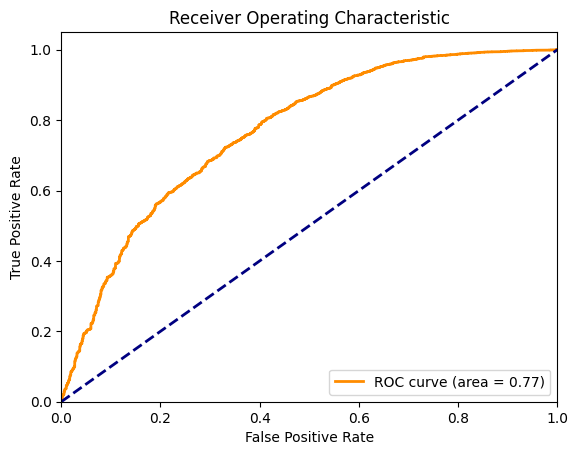

In [41]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# FPR, TPR, およびしきい値を計算する
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

# AUC（Area Under Curve）を計算する
roc_auc = auc(fpr, tpr)

# ROC曲線をプロットする
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

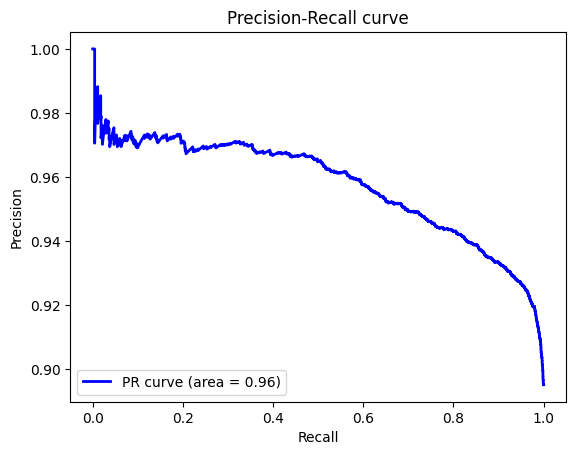

In [42]:
from sklearn.metrics import precision_recall_curve, auc

# 精度と再現率を計算
precision, recall, thresholds = precision_recall_curve(y_val, y_pred)

# PR AUCを計算
pr_auc = auc(recall, precision)

# PR曲線をプロット
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='PR curve (area = %0.2f)' % pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc="lower left")
plt.show()